# Projet 5: Segmentez des clients d'un site e-commerceSegmentez des clients d'un site e-commerce

# Importation des bibliothèques nécessaires

In [1]:
import sqlite3
import pandas as pd
import warnings
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
# Importations essentielles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px

# Configuration
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')
%matplotlib inline


In [2]:
# Désactiver l'affichage des avertissements
warnings.filterwarnings('ignore')

In [3]:
# Configurer Pandas pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)


In [4]:
df_merged = pd.read_csv('df_merged.csv')
df_merged

order_purchase_timestamp                customer_unique_id   price  \
0          2017-10-02 10:56:33  7c396fd4830fd04220f754e42b4e5bff   29.99   
1          2018-07-24 20:41:37  af07308b275d755c9edb36a90c618231  118.70   
2          2018-08-08 08:38:49  3a653a41f6f9fc3d2a113cf8398680e8  159.90   
3          2017-11-18 19:28:06  7c142cf63193a1473d2e66489a9ae977   45.00   
4          2018-02-13 21:18:39  72632f0f9dd73dfee390c9b22eb56dd6   19.90   
...                        ...                               ...     ...   
98661      2017-03-09 09:54:05  6359f309b166b0196dbf7ad2ac62bb5a   72.00   
98662      2018-02-06 12:58:58  da62f9e57a76d978d02ab5362c509660  174.90   
98663      2017-08-27 14:46:43  737520a9aad80b3fbbdad19b66b37b30  205.99   
98664      2018-01-08 21:28:27  5097a5312c8b157bb7be58ae360ef43c  179.99   
98665      2018-03-08 20:57:30  60350aa974b26ff12caad89e55993bd6   68.50   

       freight_value  payment_value  review_score  delivery_time  \
0               8.72          18.12           4.0            8.0   
1              22.76         141.46           4.0           13.0   
2              19.22         179.12           5.0            9.0   
3              27.20          72.20           5.0           13.0   
4               8.72          28.62           5.0            2.0   
...              ...            ...           ...            ...   
98661          13.08          85.08           5.0            8.0   
98662          20.10         195.00           4.0           22.0   
98663          65.02         271.01           5.0           24.0   
98664          40.59         441.16           2.0           17.0   
98665          18.36          86.86           5.0            7.0   

       delivery_delay  purchase_month  delai_livraison  \
0                -8.0              10              8.0   
1                -6.0               7             13.0   
2               -18.0               8              9.0   
3               -13.0              11             13.0   
4               -10.0               2              2.0   
...               ...             ...              ...   
98661           -11.0               3              8.0   
98662            -2.0               2             22.0   
98663            -6.0               8             24.0   
98664           -21.0               1             17.0   
98665           -18.0               3              7.0   

       delai_total_traitement  customer_state_AC  customer_state_AL  \
0                         8.0                  0                  0   
1                        13.0                  0                  0   
2                         9.0                  0                  0   
3                        13.0                  0                  0   
4                         2.0                  0                  0   
...                       ...                ...                ...   
98661                     8.0                  0                  0   
98662                    22.0                  0                  0   
98663                    24.0                  0                  0   
98664                    17.0                  0                  0   
98665                     7.0                  0                  0   

       customer_state_AM  customer_state_AP  customer_state_BA  \
0                      0                  0                  0   
1                      0                  0                  1   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
...                  ...                ...                ...   
98661                  0                  0                  0   
98662                  0                  0                  0   
98663                  0                  0                  1   
98664                  0                  0                  0   


limit_output extension: Maximum message size of 10000 exceeded with 17867 characters

## recherche de la derniere date dans mon jeu de données :p 

In [5]:
date_reference = df_merged['order_purchase_timestamp'].max()
date_reference

'2018-09-03 09:06:57'

## Calculer R, F, M pour chaque client

In [6]:
# Convertir la colonne 'order_purchase_timestamp' en datetime 
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])

In [7]:
# 1. Fixer la date de référence pour la récence (dernier achat)
date_reference = df_merged['order_purchase_timestamp'].max()

# 2. Calculer R (Récence), F (Fréquence) et M (Monétaire)
rfm = df_merged.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda x: (date_reference - x.max()).days),
    frequency=('customer_unique_id', 'count'),
    monetary=('price', 'sum')
).reset_index()

# 3. Attribuer des scores de 1 à 5 pour R (Récence) en utilisant `qcut`
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# 4. Attribuer des scores pour F (Fréquence) en utilisant un regroupement manuel
def assign_frequency_score(frequency):
    if frequency == 1:
        return 1  # Clients ayant acheté une seule fois
    else:
        return 5  # Clients ayant acheté plus de 2 fois

# Appliquer la fonction pour attribuer le score de fréquence
rfm['F_score'] = rfm['frequency'].apply(assign_frequency_score)

# 5. Attribuer des scores de 1 à 5 pour M (Monétaire) en utilisant `qcut`
rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# 6. Créer une nouvelle colonne pour F + M (F + M seront additionnés pour obtenir une combinaison de scores)
rfm['FM'] = rfm['F_score'].astype(int) + rfm['M_score'].astype(int)

# CALCULER rfm_score : 
rfm['RFM_score'] = rfm['F_score'].astype(int) + rfm['M_score'].astype(int) + rfm['R_score'].astype(int)

# 7. Créer une matrice RFM
rfm_matrix = rfm.pivot_table(index='FM', columns='R_score', values='customer_unique_id', aggfunc='count', fill_value=0)

# Afficher la matrice de segmentation RFM
rfm_matrix

# Optionnel : Afficher les premiers résultats du DataFrame RFM
rfm.head()


,customer_unique_id,recency,frequency,monetary,R_score,F_score,M_score,FM,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,2,3,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,5,6,10
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,3,4,5
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,5,6,8
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,1,2,4


## merger rfm avec df_merged

In [8]:
df_merged = pd.merge(df_merged, rfm, on='customer_unique_id', how='inner')

In [9]:
rfm['R_score'].value_counts()

5    19206
2    19153
3    19119
4    18980
1    18962
Name: R_score, dtype: int64

In [10]:
# 1. Création de la matrice RFM (en utilisant FM comme index et R_score comme colonne)
rfm_matrix = rfm.pivot_table(index='FM', columns='R_score', values='customer_unique_id', aggfunc='count', fill_value=0)

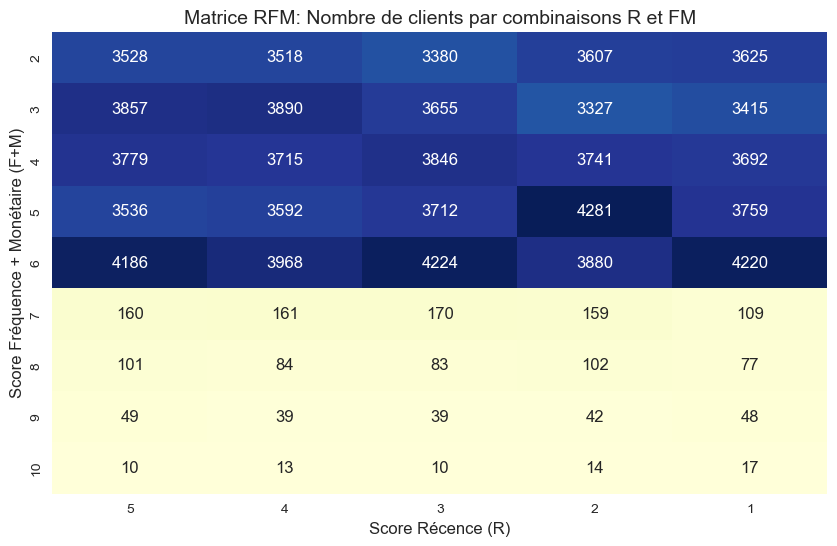

In [11]:
# 2. Visualisation de la matrice RFM avec heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_matrix, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title("Matrice RFM: Nombre de clients par combinaisons R et FM", fontsize=14)
plt.xlabel("Score Récence (R)", fontsize=12)
plt.ylabel("Score Fréquence + Monétaire (F+M)", fontsize=12)
plt.show() 

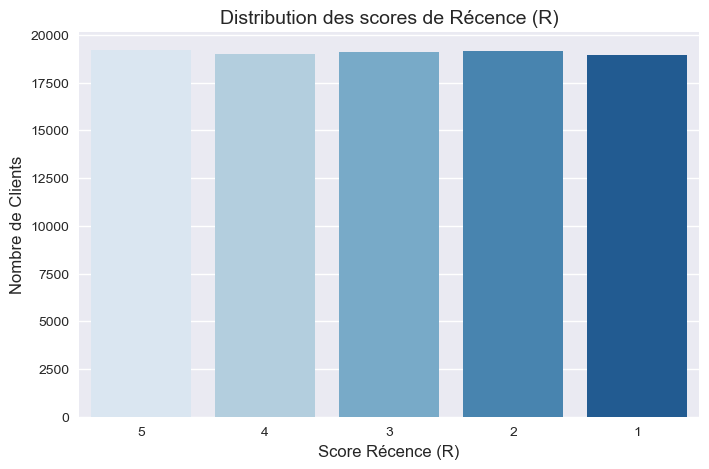

In [12]:
# 3. Visualisation de la distribution des scores R, F, et M avec des barplots

# Distribution des scores Récence (R)
plt.figure(figsize=(8, 5))
sns.countplot(x='R_score', data=rfm, palette='Blues')
plt.title('Distribution des scores de Récence (R)', fontsize=14)
plt.xlabel('Score Récence (R)', fontsize=12)
plt.ylabel('Nombre de Clients', fontsize=12)
plt.show()



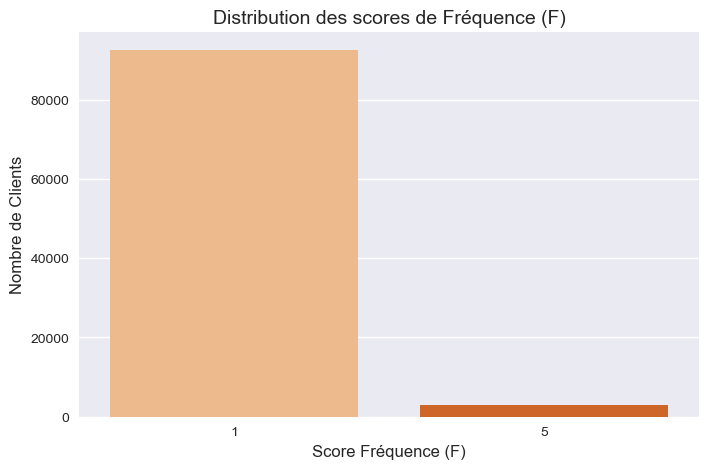

In [13]:
# Distribution des scores Fréquence (F)
plt.figure(figsize=(8, 5))
sns.countplot(x='F_score', data=rfm, palette='Oranges')
plt.title('Distribution des scores de Fréquence (F)', fontsize=14)
plt.xlabel('Score Fréquence (F)', fontsize=12)
plt.ylabel('Nombre de Clients', fontsize=12)
plt.show()



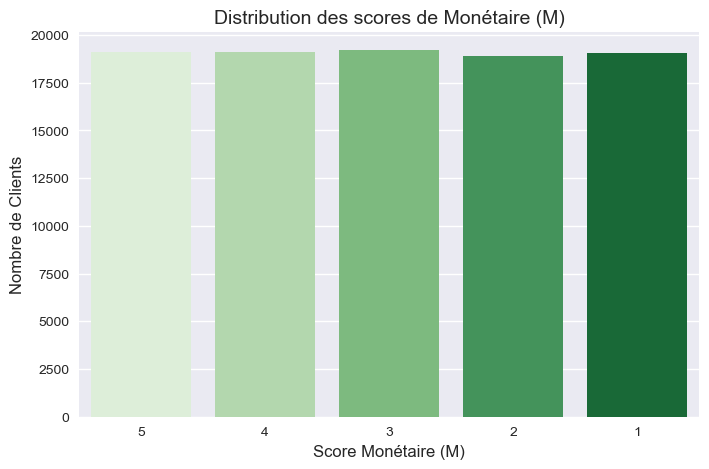

In [14]:
# Distribution des scores Monétaire (M)
plt.figure(figsize=(8, 5))
sns.countplot(x='M_score', data=rfm, palette='Greens')
plt.title('Distribution des scores de Monétaire (M)', fontsize=14)
plt.xlabel('Score Monétaire (M)', fontsize=12)
plt.ylabel('Nombre de Clients', fontsize=12)
plt.show()



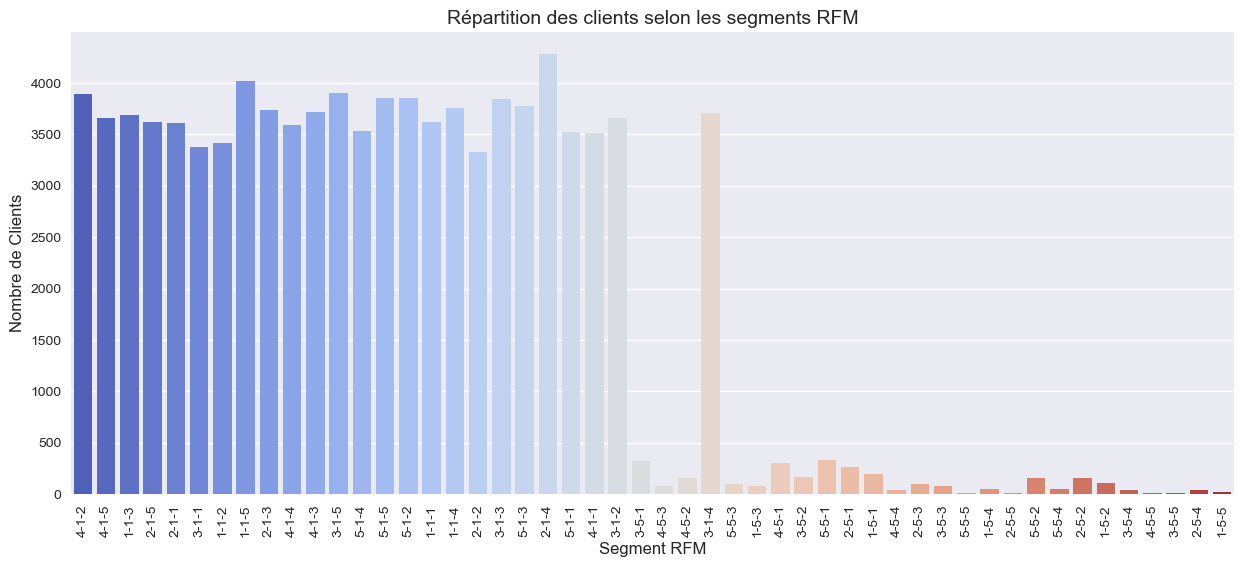

In [15]:
# 4. Visualisation de la répartition des clients dans les segments RFM (R + F + M combinés)
rfm['RFM_segment'] = rfm['R_score'].astype(str) + '-' + rfm['F_score'].astype(str) + '-' + rfm['M_score'].astype(str)

# Répartition des segments RFM
plt.figure(figsize=(15, 6))
sns.countplot(x='RFM_segment', data=rfm, palette='coolwarm')
plt.title('Répartition des clients selon les segments RFM', fontsize=14)
plt.xlabel('Segment RFM', fontsize=12)
plt.ylabel('Nombre de Clients', fontsize=12)
plt.xticks(rotation=90)
plt.show()



In [16]:
# Convertir les scores F et M en type entier (int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

# Créer une nouvelle colonne 'Total_FM' en additionnant F_score et M_score
rfm['Total_FM'] = rfm['F_score'] + rfm['M_score']

# Trier les clients par leur score total F + M et afficher les top 10
top_10_clients = rfm.sort_values(by='Total_FM', ascending=False).head(10)

# Afficher le tableau des top 10 clients
print("Top 10 clients par score total F + M")
print(top_10_clients[['customer_unique_id', 'R_score', 'F_score', 'M_score', 'Total_FM']])


Top 10 clients par score total F + M
                     customer_unique_id R_score  F_score  M_score  Total_FM
92400  f7be9bec658c62ab6240b44cd26c0b84       1        5        5        10
29857  4fe67915d44791a5deab2957c2641048       1        5        5        10
91208  f497dd3ee9e4ef33b42acd82713e4bf3       5        5        5        10
80361  d753459418d268407f19b64be28e3c5a       1        5        5        10
32901  580561d937f063a0c4ffe1e4832df2f5       3        5        5        10
89445  efd22f5f8fc7e5035a4f48bd92c0c69c       4        5        5        10
13392  23b2d37ef78f3c8dcb31f5eefc30190a       3        5        5        10
83615  dffdc8e60eab79300b75d9febd9eec46       4        5        5        10
41194  6e2f539e9e0e323859a81079581db712       4        5        5        10
76446  ccd2f7d983d761b9c7520a266bfcfc81       2        5        5        10


## ajouter d'autres infos : 

In [17]:
# Extraire des features
df_merged['order_year'] = df_merged['order_purchase_timestamp'].dt.year
df_merged['order_month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['order_day'] = df_merged['order_purchase_timestamp'].dt.day
df_merged['order_dayofweek'] = df_merged['order_purchase_timestamp'].dt.dayofweek  # 0 = lundi, 6 = dimanche
df_merged['order_hour'] = df_merged['order_purchase_timestamp'].dt.hour
df_merged['is_weekend'] = df_merged['order_dayofweek'].isin([5, 6]).astype(int)  # 1 si week-end, 0 sinon

# Encodage cyclique pour le mois et le jour de la semaine (optionnel)
df_merged['order_month_sin'] = np.sin(2 * np.pi * df_merged['order_month'] / 12)
df_merged['order_month_cos'] = np.cos(2 * np.pi * df_merged['order_month'] / 12)
df_merged['order_dayofweek_sin'] = np.sin(2 * np.pi * df_merged['order_dayofweek'] / 7)
df_merged['order_dayofweek_cos'] = np.cos(2 * np.pi * df_merged['order_dayofweek'] / 7)

# Supprimer la colonne de date originale
df_merged.drop(columns=['order_purchase_timestamp'], inplace=True)


In [18]:
# Extraire les identifiants
customer_ids = df_merged['customer_unique_id']

# # Supprimer la colonne du DataFrame
# df_merged.drop(columns=['customer_id'], inplace=True)

In [19]:
df_merged

customer_unique_id   price  freight_value  payment_value  \
0      7c396fd4830fd04220f754e42b4e5bff   29.99           8.72          18.12   
1      7c396fd4830fd04220f754e42b4e5bff   35.39           8.72          44.11   
2      af07308b275d755c9edb36a90c618231  118.70          22.76         141.46   
3      3a653a41f6f9fc3d2a113cf8398680e8  159.90          19.22         179.12   
4      7c142cf63193a1473d2e66489a9ae977   45.00          27.20          72.20   
...                                 ...     ...            ...            ...   
98661  6359f309b166b0196dbf7ad2ac62bb5a   72.00          13.08          85.08   
98662  da62f9e57a76d978d02ab5362c509660  174.90          20.10         195.00   
98663  737520a9aad80b3fbbdad19b66b37b30  205.99          65.02         271.01   
98664  5097a5312c8b157bb7be58ae360ef43c  179.99          40.59         441.16   
98665  60350aa974b26ff12caad89e55993bd6   68.50          18.36          86.86   

       review_score  delivery_time  delivery_delay  purchase_month  \
0               4.0            8.0            -8.0              10   
1               5.0            1.0           -10.0               9   
2               4.0           13.0            -6.0               7   
3               5.0            9.0           -18.0               8   
4               5.0           13.0           -13.0              11   
...             ...            ...             ...             ...   
98661           5.0            8.0           -11.0               3   
98662           4.0           22.0            -2.0               2   
98663           5.0           24.0            -6.0               8   
98664           2.0           17.0           -21.0               1   
98665           5.0            7.0           -18.0               3   

       delai_livraison  delai_total_traitement  customer_state_AC  \
0                  8.0                     8.0                  0   
1                  1.0                     1.0                  0   
2                 13.0                    13.0                  0   
3                  9.0                     9.0                  0   
4                 13.0                    13.0                  0   
...                ...                     ...                ...   
98661              8.0                     8.0                  0   
98662             22.0                    22.0                  0   
98663             24.0                    24.0                  0   
98664             17.0                    17.0                  0   
98665              7.0                     7.0                  0   

       customer_state_AL  customer_state_AM  customer_state_AP  \
0                      0                  0                  0   
1                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
...                  ...                ...                ...   
98661                  0                  0                  0   
98662                  0                  0                  0   
98663                  0                  0                  0   
98664                  0                  0                  0   
98665                  0                  0                  0   

       customer_state_BA  customer_state_CE  customer_state_DF  \
0                      0                  0                  0   
1                      0                  0                  0   
2                      1                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
...                  ...                ...                ...   
98661                  0                  0                  0   
98662                  0                  0              

limit_output extension: Maximum message size of 10000 exceeded with 20570 characters

## Essaie d'autres modèles qui permettent la segmentation.

## Segmentation avec K-MEANS 

[INFO] Début de l'exécution principale...
[INFO] Lancement du pipeline complet...

[INFO] Démarrage du prétraitement des données...
[INFO] Variables numériques identifiées : 76
[INFO] Imputation des valeurs manquantes (médiane)...

[INFO] Application du traitement des outliers...
[INFO] Prétraitement terminé.

[INFO] Standardisation robuste pour sélection de variables...

[INFO] Sélection hybride des variables en cours...
[INFO] Étape 1 : Filtrage par variance...
[INFO] Variables restantes après filtrage par variance : 23
[INFO] Étape 2 : Élimination des variables fortement corrélées...
[INFO] Variables restantes après filtrage de corrélation : 18
[INFO] Étape 3 : Sélection par importance via ACP...
[INFO] Variables sélectionnées : ['freight_value', 'delivery_delay', 'delivery_time', 'review_score', 'order_month_cos', 'price', 'purchase_month', 'recency', 'order_dayofweek_sin', 'order_dayofweek_cos', 'RFM_score', 'customer_state_SP', 'order_dayofweek', 'order_month_sin', 'FM', 'order_d

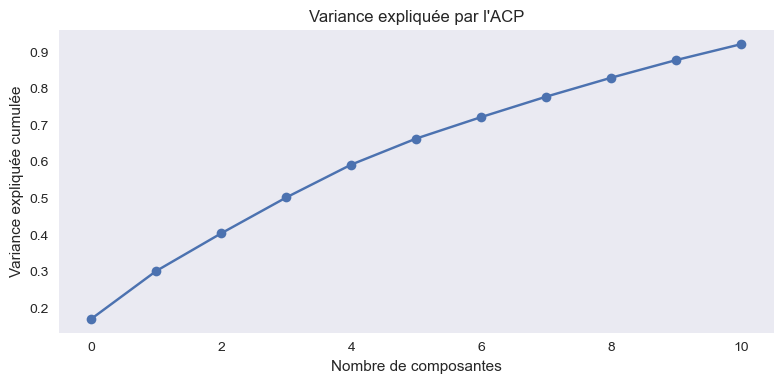


[INFO] Affichage des graphes du coude et silhouette...
[INFO] Test avec k = 2...
[INFO] Test avec k = 3...
[INFO] Test avec k = 4...
[INFO] Test avec k = 5...
[INFO] Test avec k = 6...
[INFO] Test avec k = 7...
[INFO] Test avec k = 8...
[INFO] Test avec k = 9...
[INFO] Test avec k = 10...


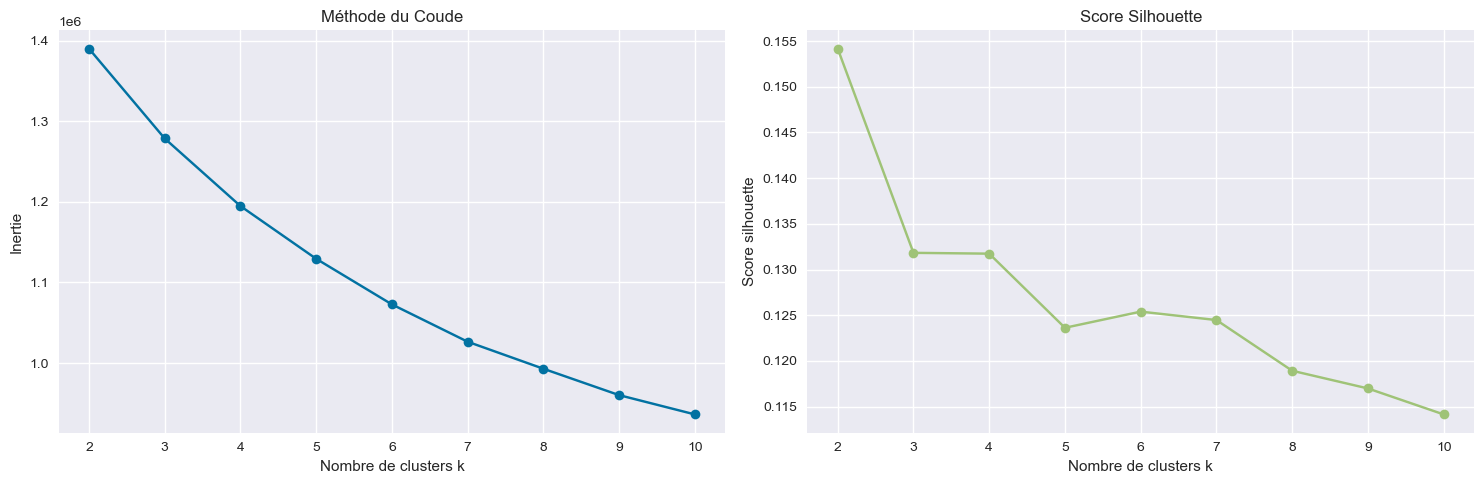


👉 Veuillez entrer le nombre de clusters k (ex: 3) après avoir observé les graphiques : 2

[INFO] Application du K-means avec k = 2...

[INFO] Analyse des clusters...

Caractéristiques moyennes par cluster :
         freight_value  delivery_delay  delivery_time  review_score  \
cluster                                                               
0            18.124261      -11.633277      11.072753      4.292449   
1            17.749492      -12.644078      11.931808      4.291205   

         order_month_cos       price  purchase_month     recency  \
cluster                                                            
0              -0.272360  102.282363        4.414309  126.647626   
1               0.068523  102.535583        7.992261  382.485984   

         order_dayofweek_sin  order_dayofweek_cos  RFM_score  \
cluster                                                        
0                   0.094201             0.025390   8.295354   
1                   0.061827             0

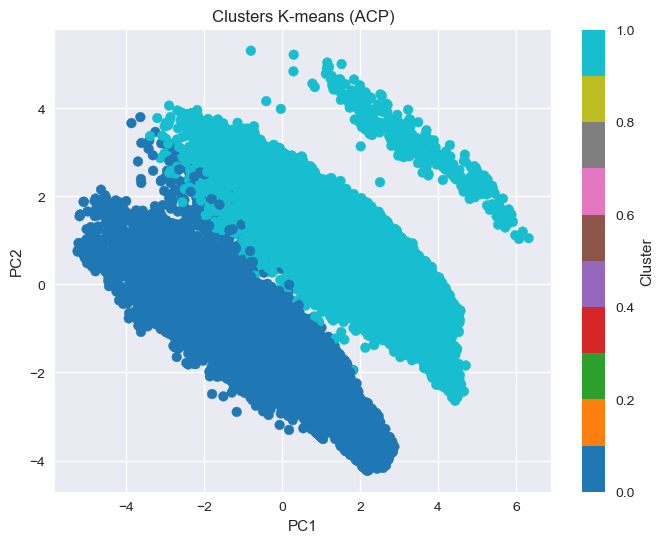

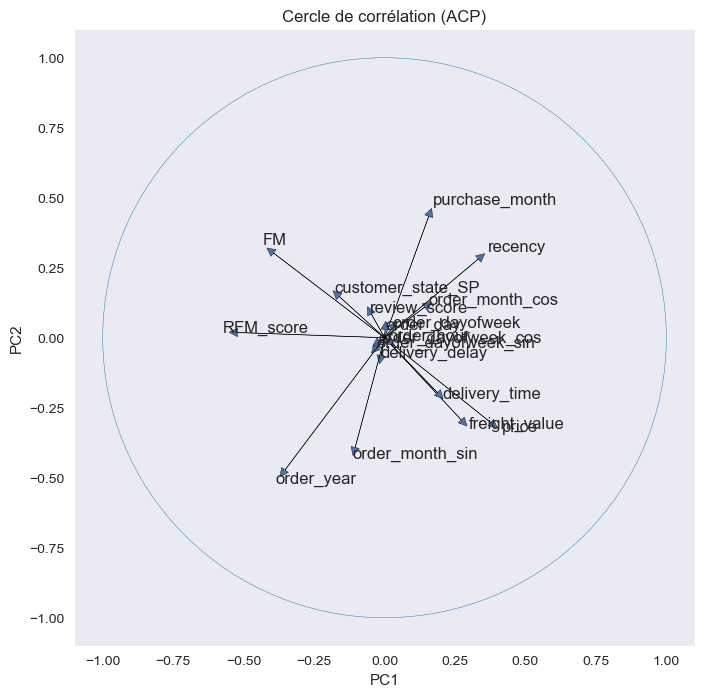


[INFO] Données avec clusters sauvegardées dans : resultats_clustering.csv

[INFO] Résumé des clusters :
         freight_value  delivery_delay  delivery_time  review_score  \
cluster                                                               
0            18.124261      -11.633277      11.072753      4.292449   
1            17.749492      -12.644078      11.931808      4.291205   

         order_month_cos       price  purchase_month     recency  \
cluster                                                            
0              -0.272360  102.282363        4.414309  126.647626   
1               0.068523  102.535583        7.992261  382.485984   

         order_dayofweek_sin  order_dayofweek_cos  RFM_score  \
cluster                                                        
0                   0.094201             0.025390   8.295354   
1                   0.061827             0.007442   5.913123   

         customer_state_SP  order_dayofweek  order_month_sin        FM  \
cluste

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score

# ==============================
# 1. PRÉTRAITEMENT DES DONNÉES
# ==============================

def cap_outliers_vectorized(df, cols):
    print("\n[INFO] Application du traitement des outliers...")
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[cols].clip(lower=lower, upper=upper, axis=1)

def preprocess_data(df):
    print("\n[INFO] Démarrage du prétraitement des données...")
    num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"[INFO] Variables numériques identifiées : {len(num_vars)}")

    print("[INFO] Imputation des valeurs manquantes (médiane)...")
    imputer = SimpleImputer(strategy='median')
    df[num_vars] = imputer.fit_transform(df[num_vars])

    df[num_vars] = cap_outliers_vectorized(df, num_vars)

    print("[INFO] Prétraitement terminé.")
    return df, num_vars

# ==============================
# 2. SÉLECTION DE VARIABLES
# ==============================

def hybrid_feature_selector(X, n_features=20):
    print("\n[INFO] Sélection hybride des variables en cours...")

    print("[INFO] Étape 1 : Filtrage par variance...")
    var_selector = VarianceThreshold(threshold=0.1)
    X_var = var_selector.fit_transform(X)
    high_var_cols = X.columns[var_selector.get_support()]
    print(f"[INFO] Variables restantes après filtrage par variance : {len(high_var_cols)}")

    print("[INFO] Étape 2 : Élimination des variables fortement corrélées...")
    corr_matrix = pd.DataFrame(X_var, columns=high_var_cols).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
    filtered_cols = [col for col in high_var_cols if col not in to_drop]
    print(f"[INFO] Variables restantes après filtrage de corrélation : {len(filtered_cols)}")

    print("[INFO] Étape 3 : Sélection par importance via ACP...")
    pca = PCA(n_components=0.95)
    pca.fit(X[filtered_cols])
    loadings = pd.DataFrame(pca.components_, columns=filtered_cols)
    importance = loadings.abs().mean(axis=0).sort_values(ascending=False)

    selected = importance.head(n_features).index.tolist()
    print(f"[INFO] Variables sélectionnées : {selected}")
    return selected

# =========================
# 3. ANALYSE EN COMPOSANTES
# =========================

def perform_pca(X, variance_threshold=0.9):
    print("\n[INFO] Lancement de l'ACP...")
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X)
    print(f"[INFO] Composantes principales retenues : {pca.n_components_}")
    print(f"[INFO] Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")

    plt.figure(figsize=(8,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Nombre de composantes")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée par l'ACP")
    plt.grid()
    plt.tight_layout()
    plt.savefig("variance_expliquee_acp.png")
    plt.show()

    return X_pca, pca

# ====================
# 4. CLUSTERING
# ====================

def run_kmeans(X_pca, k):
    print(f"\n[INFO] Application du K-means avec k = {k}...")
    model = KMeans(n_clusters=k, random_state=42)
    return model.fit_predict(X_pca)

# ========================
# 5. VISUALISATIONS
# ========================

def plot_correlation_circle(pca, features):
    pcs = pca.components_
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03)
        plt.text(x*1.1, y*1.1, features[i], fontsize=12)
    circle = plt.Circle((0, 0), 1, color='b', fill=False)
    ax.add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.title("Cercle de corrélation (ACP)")
    plt.savefig("cercle_correlation.png")
    plt.show()

# ====================
# 6. PIPELINE GLOBAL
# ====================

def full_pipeline(df):
    print("[INFO] Lancement du pipeline complet...")

    customer_ids = df['customer_id'] if 'customer_id' in df.columns else None
    df_clean, num_vars = preprocess_data(df)

    print("\n[INFO] Standardisation robuste pour sélection de variables...")
    X_robust = pd.DataFrame(RobustScaler().fit_transform(df_clean[num_vars]), columns=num_vars)
    selected_vars = hybrid_feature_selector(X_robust)

    print("\n[INFO] Standardisation classique pour ACP...")
    X_final = pd.DataFrame(StandardScaler().fit_transform(df_clean[selected_vars]), columns=selected_vars)

    try:
        X_pca, pca_model = perform_pca(X_final)

        print("\n[INFO] Affichage des graphes du coude et silhouette...")
        inertias = []
        silhouettes = []
        k_range = range(2, 11)
        for k in k_range:
            print(f"[INFO] Test avec k = {k}...")
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X_pca)
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(X_pca, labels))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_title('Méthode du Coude')
        ax1.set_xlabel("Nombre de clusters k")
        ax1.set_ylabel("Inertie")
        ax1.grid(True)

        ax2.plot(k_range, silhouettes, 'go-')
        ax2.set_title('Score Silhouette')
        ax2.set_xlabel("Nombre de clusters k")
        ax2.set_ylabel("Score silhouette")
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig("elbow_silhouette.png")
        plt.show()

        while True:
            try:
                k = int(input("\n👉 Veuillez entrer le nombre de clusters k (ex: 3) après avoir observé les graphiques : "))
                if k < 2 or k > 10:
                    print("Veuillez choisir un entier entre 2 et 10.")
                    continue
                break
            except ValueError:
                print("Entrée invalide. Veuillez entrer un nombre entier.")

        clusters = run_kmeans(X_pca, k)

    except Exception as e:
        print(f"[ERREUR] Problème durant ACP ou clustering : {e}")
        return df_clean, None

    df_clean['cluster'] = clusters
    if customer_ids is not None:
        df_clean['customer_id'] = customer_ids.values

    print("\n[INFO] Analyse des clusters...")
    cluster_stats = df_clean.groupby('cluster')[selected_vars].mean()
    print("\nCaractéristiques moyennes par cluster :")
    print(cluster_stats)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Clusters K-means (ACP)")
    plt.colorbar(label="Cluster")
    plt.savefig("clusters_2D.png")
    plt.show()

    plot_correlation_circle(pca_model, selected_vars)

    output_path = "resultats_clustering.csv"
    df_clean.to_csv(output_path, index=False)
    print(f"\n[INFO] Données avec clusters sauvegardées dans : {output_path}")

    return df_clean, cluster_stats

# ====================
# 7. EXÉCUTION
# ====================

if __name__ == "__main__":
    print("[INFO] Début de l'exécution principale...")

    # df_merged doit être défini avant (chargé depuis fichier ou construit)
    df_result, stats = full_pipeline(df_merged)

    print("\n[INFO] Résumé des clusters :")
    print(stats)


In [21]:
df_result['cluster'].value_counts()

0    54218
1    44448
Name: cluster, dtype: int64

In [31]:
df_result.columns 

Index(['customer_unique_id', 'price', 'freight_value', 'payment_value',
       'review_score', 'delivery_time', 'delivery_delay', 'purchase_month',
       'delai_livraison', 'delai_total_traitement', 'customer_state_AC',
       'customer_state_AL', 'customer_state_AM', 'customer_state_AP',
       'customer_state_BA', 'customer_state_CE', 'customer_state_DF',
       'customer_state_ES', 'customer_state_GO', 'customer_state_MA',
       'customer_state_MG', 'customer_state_MS', 'customer_state_MT',
       'customer_state_PA', 'customer_state_PB', 'customer_state_PE',
       'customer_state_PI', 'customer_state_PR', 'customer_state_RJ',
       'customer_state_RN', 'customer_state_RO', 'customer_state_RR',
       'customer_state_RS', 'customer_state_SC', 'customer_state_SE',
       'customer_state_SP', 'customer_state_TO', 'payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher', 'purchase_day_Friday', 'purchase_day_Monday',
       '

## faire la meme chose avce db scan : (Density-Based Spatial Clustering of Applications with Noise)

### 1. Préparation des Données (identique à K-means)


In [28]:
# Sélection des variables numériques
num_vars = df_merged.select_dtypes(include=[np.number]).columns.tolist()

# Nettoyage et standardisation
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_merged[num_vars].fillna(df_merged[num_vars].median())), 
                        columns=num_vars)

###  Sélection des Variables (optionnel pour DBSCAN)


In [29]:
# Méthode 1 : Réduction de dimension avec PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)  # Conserve 90% de la variance
X_pca = pca.fit_transform(X_scaled)

###  Détermination des Hyperparamètres DBSCAN


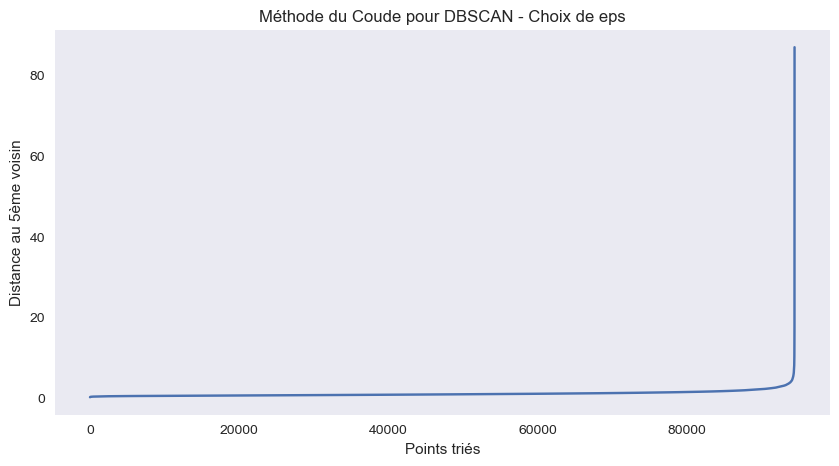

In [30]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calcul des distances aux k plus proches voisins
nn = NearestNeighbors(n_neighbors=5).fit(X_pca)
distances, _ = nn.kneighbors(X_pca)
distances = np.sort(distances[:, -1])

# Graphique du "coude" pour choisir eps
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel('Points triés')
plt.ylabel('Distance au 5ème voisin')
plt.title('Méthode du Coude pour DBSCAN - Choix de eps')
plt.grid()
plt.show()

### Approche Alternative / autre technique 


In [31]:
# Calculer la distance moyenne au plus proche voisin
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2).fit(X_pca)
distances, _ = nn.kneighbors(X_pca)
mean_distance = distances[:,1].mean()

# Estimation automatique de eps
suggested_eps = round(mean_distance * 1.5, 2)
print(f"Valeur suggérée pour eps : {suggested_eps}")

Valeur suggérée pour eps : 1.2


###  Clustering avec DBSCAN


In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(X_pca)

# Analyse des résultats
df_merged['cluster_dbscan'] = clusters
print("Répartition des clusters :")
print(df_merged['cluster_dbscan'].value_counts())

# -1 = Noise (points aberrants)

Répartition des clusters :
-1     94208
 7        11
 10       10
 11        9
 21        8
 3         7
 33        7
 8         7
 32        7
 1         7
 36        6
 6         6
 4         6
 2         6
 9         6
 12        6
 5         6
 25        6
 37        5
 34        5
 29        5
 28        5
 26        5
 19        5
 27        5
 23        5
 31        5
 22        5
 15        5
 18        5
 38        5
 35        5
 16        5
 14        5
 17        5
 0         5
 20        5
 13        5
 24        5
 30        5
Name: cluster_dbscan, dtype: int64


In [33]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(X_pca)

# Analyse des résultats
df_merged['cluster_dbscan'] = clusters
print("Répartition des clusters :")
print(df_merged['cluster_dbscan'].value_counts())

# -1 = Noise (points aberrants)

Répartition des clusters :
 1     40145
 2     32074
-1     19521
 0      1634
 3       454
       ...  
 71        3
 78        2
 63        2
 27        2
 82        1
Name: cluster_dbscan, Length: 113, dtype: int64


In [34]:
# Version optimisée
dbscan = DBSCAN(eps=2.5,  # Augmenter le rayon
                min_samples=10,  # Exiger plus de points pour former un cluster
                metric='euclidean')
clusters = dbscan.fit_predict(X_pca)



In [35]:
# Analyse des résultats
df_merged['cluster_dbscan'] = clusters
print("Répartition des clusters :")
print(df_merged['cluster_dbscan'].value_counts())


Répartition des clusters :
 1    86693
 0     5204
-1     2494
 2       11
 3       10
 4       10
 6        9
 5        8
Name: cluster_dbscan, dtype: int64


###  Visualisation


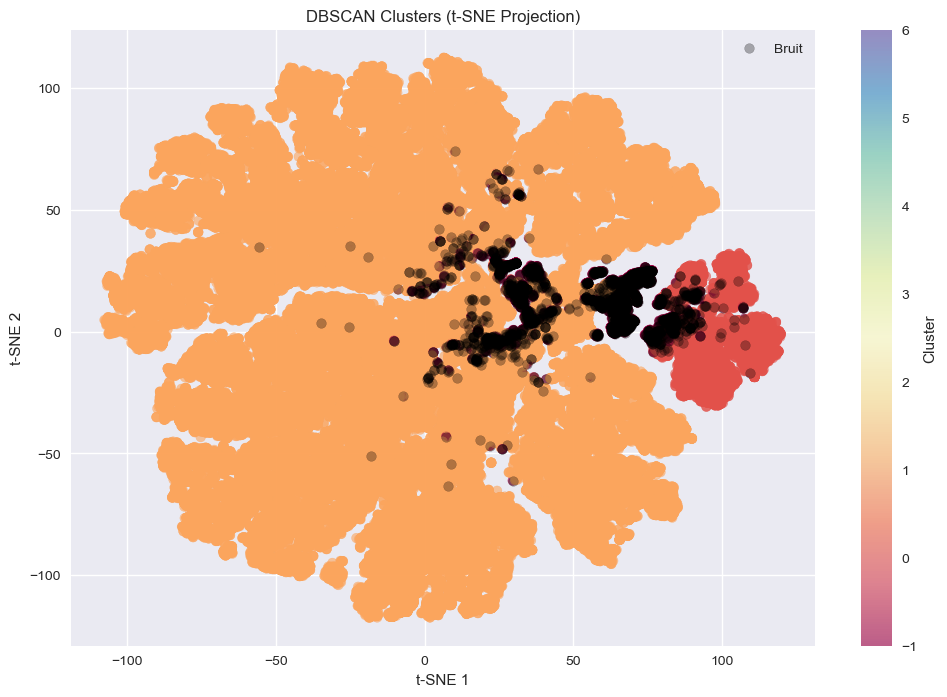

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE pour meilleure visualisation
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_pca)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c=clusters, cmap='Spectral', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('DBSCAN Clusters (t-SNE Projection)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Encadrer le bruit en noir
if -1 in clusters:
    noise_mask = (clusters == -1)
    plt.scatter(X_embedded[noise_mask,0], X_embedded[noise_mask,1], 
                c='black', alpha=0.3, label='Bruit')
    plt.legend()

plt.show()

In [37]:
# Option 1 : HDBSCAN (meilleur pour les densités variables)
!pip install hdbscan
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=50)
clusters_hdb = hdb.fit_predict(X_pca)

# Option 2 : DBSCAN avec métrique adaptée
dbscan_cosine = DBSCAN(eps=0.5, min_samples=5, metric='cosine')

  Obtaining dependency information for hdbscan from https://files.pythonhosted.org/packages/64/b1/96c347c7740efa1ac803be64155159284f92fafcff88c1077344e64eead5/hdbscan-0.8.40-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
   ------ --------------------------------- 112.6/732.2 kB 6.4 MB/s eta 0:00:01
   ----------- ---------------------------- 204.8/732.2 kB 3.1 MB/s eta 0:00:01
   ---------------- ----------------------- 307.2/732.2 kB 2.7 MB/s eta 0:00:01
   ---------------------- ----------------- 419.8/732.2 kB 2.9 MB/s eta 0:00:01
   ----------------------------- ---------- 532.5/732.2 kB 2.8 MB/s eta 0:00:01
   ------------------------------------- -- 686.1/732.2 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 732.2/732.2 kB 2.9 MB/s eta 0:00:00


###  Analyse des Clusters


In [38]:
# Statistiques par cluster
cluster_stats = df_merged.groupby('cluster_dbscan')[num_vars].mean()

# Comparaison avec K-means (si disponible)
if 'cluster_kmeans' in df_merged.columns:
    from sklearn.metrics import adjusted_rand_score
    print("\nConcordance DBSCAN/K-means :", 
          adjusted_rand_score(df_merged['cluster_dbscan'], df_merged['cluster_kmeans']))

###  Sauvegarde des Résultats
 

In [39]:
# Export des données clusterisées
df_merged.to_csv('clusters_dbscan.csv', index=False)

# Export du modèle (DBSCAN ne peut pas être ré-entraîné, mais on sauvegarde le preprocessing)
import joblib
joblib.dump({
    'scaler': scaler,
    'pca': pca if 'pca' in locals() else None,
    'features': num_vars,
    'dbscan_params': {'eps': 0.3, 'min_samples': 5}
}, 'dbscan_model.pkl')

['dbscan_model.pkl']

## Clustering Hiérarchique (CAH)

###  Préparation des Données (identique à DBSCAN/K-means)


In [40]:
# Échantillonnage reproductible (30%)
np.random.seed(42)
sample_idx = np.random.choice(len(df_merged), size=int(len(df_merged)*0.3), replace=False)
df_sample = df_merged.iloc[sample_idx].copy()

# Sélection et nettoyage des variables numériques
num_vars = df_sample.select_dtypes(include=[np.number]).columns.tolist()
df_sample[num_vars] = df_sample[num_vars].fillna(df_sample[num_vars].median())

# Standardisation robuste
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_sample[num_vars])

### Réduction de Dimension (optionnel mais recommandé)


In [41]:
# ACP pour conserver 95% de la variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Réduction à {X_pca.shape[1]} dimensions (Variance expliquée : {pca.explained_variance_ratio_.sum():.2%})")

Réduction à 18 dimensions (Variance expliquée : 95.33%)


###  Clustering Hiérarchique


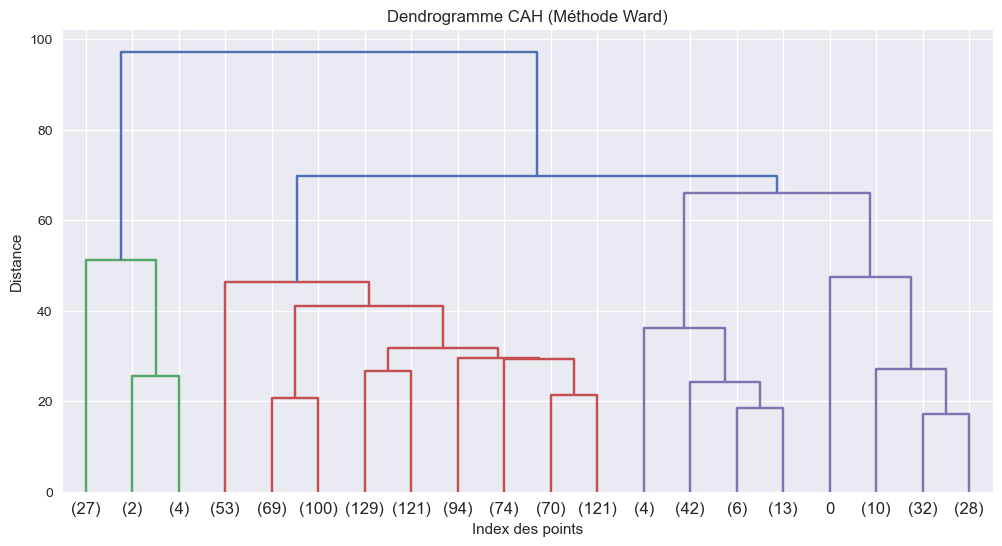

In [42]:
# Sous-échantillon pour le dendrogramme (max 1000 points pour lisibilité)
dendro_idx = np.random.choice(len(X_pca), size=min(1000, len(X_pca)), replace=False)
Z = linkage(X_pca[dendro_idx], method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title('Dendrogramme CAH (Méthode Ward)')
plt.xlabel('Index des points')
plt.ylabel('Distance')
plt.axhline(y=150, color='r', linestyle='--')  # Ajuster ce seuil
plt.show()

### 4. Choix du Nombre de Clusters ( Méthode tomatique) 


In [43]:
# Choix automatique via silhouette
from sklearn.metrics import silhouette_score

k_range = range(2, 8)
scores = []
for k in k_range:
    cah = AgglomerativeClustering(n_clusters=4, linkage='ward')
    labels = cah.fit_predict(X_pca)
    scores.append(silhouette_score(X_pca, labels))

optimal_k = k_range[np.argmax(scores)]
print(f"Nombre optimal de clusters (silhouette) : {optimal_k}")

# Clustering final
cah = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df_sample['cluster'] = cah.fit_predict(X_pca)

Nombre optimal de clusters (silhouette) : 2


In [52]:
scores

[0.5826763677101281,
 0.5248985106593852,
 0.3670711561782989,
 0.263178792765829,
 0.15794767734928758,
 0.16360652174078483]

In [53]:
optimal_k = 2

### Visualisation : 

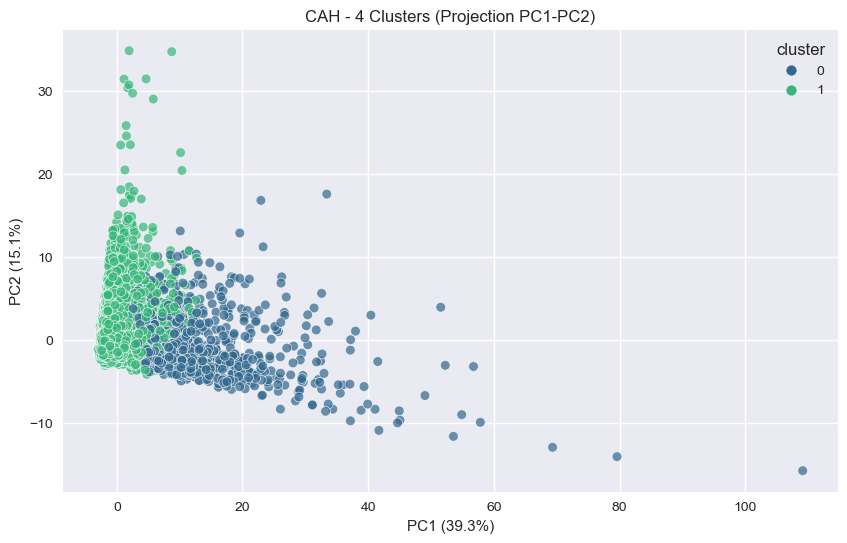

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_sample['cluster'], palette='viridis', alpha=0.7)
plt.title(f'CAH - {optimal_k} Clusters (Projection PC1-PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.show()

###  Heatmap des Caractéristiques


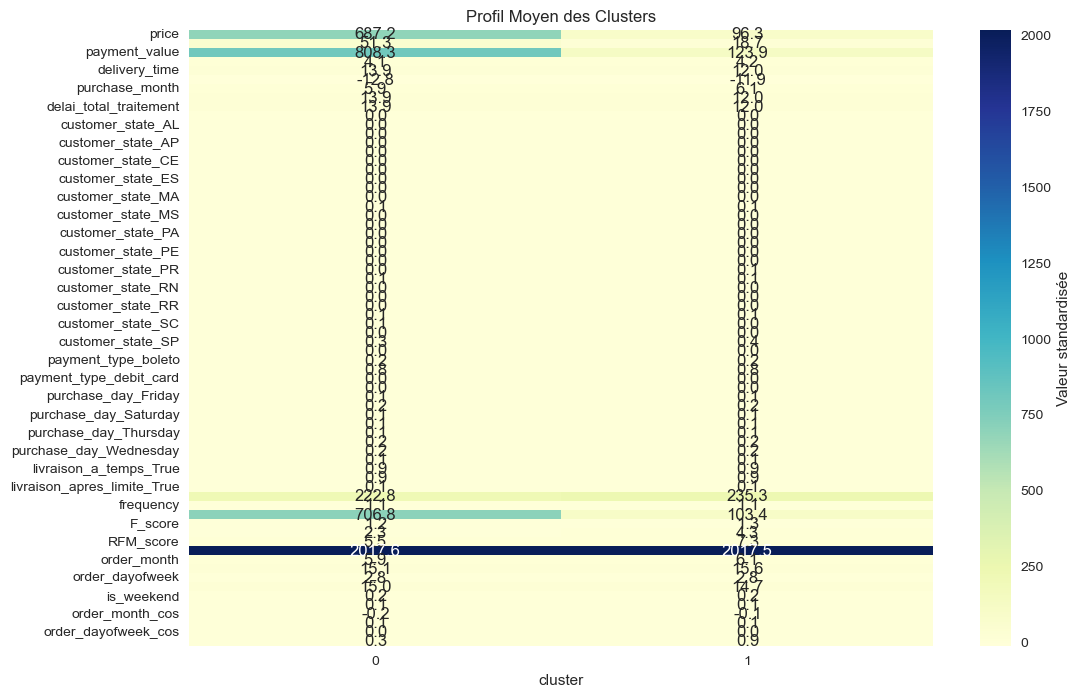

In [45]:
# Moyennes par cluster
cluster_stats = df_sample.groupby('cluster')[num_vars].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_stats.T, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Valeur standardisée'})
plt.title('Profil Moyen des Clusters')
plt.show()

###  Cercle de Corrélation (ACP)


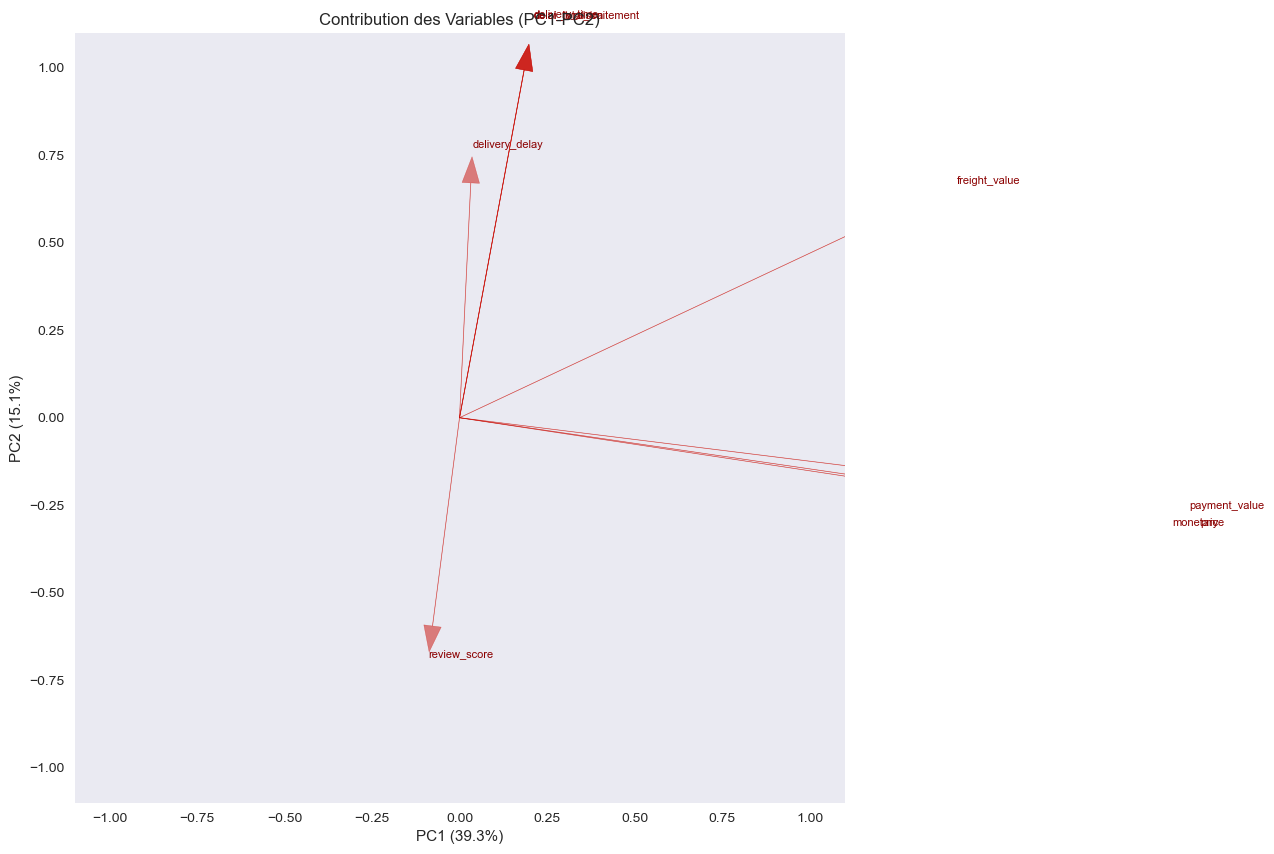

In [51]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')

for i, (x, y) in enumerate(zip(loadings[:,0], loadings[:,1])):
    if np.sqrt(x**2 + y**2) > 0.3:  # Seuil de visibilité
        plt.arrow(0, 0, x, y, head_width=0.05, color='r', alpha=0.5)
        plt.text(x*1.15, y*1.15, num_vars[i], color='darkred', fontsize=8)

plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Contribution des Variables (PC1-PC2)')
plt.grid()
plt.show()

###  Analyse des Résultats


In [47]:
print("\nTaille des clusters :")
print(df_sample['cluster'].value_counts())

print("\nVariables les plus discriminantes :")
top_features = cluster_stats.apply(lambda x: x.nlargest(3).index.tolist(), axis=1)
for cl, features in top_features.items():
    print(f"Cluster {cl} : {features}")


Taille des clusters :
1    26988
0     1343
Name: cluster, dtype: int64

Variables les plus discriminantes :
Cluster 0 : ['order_year', 'payment_value', 'monetary']
Cluster 1 : ['order_year', 'recency', 'payment_value']


### Sauvegarde 

In [48]:
import joblib

# Sauvegarde des artefacts
joblib.dump({
    'scaler': scaler,
    'pca': pca,
    'model': cah,
    'sample_idx': sample_idx  # Pour retracer l'échantillon
}, 'cah_model.pkl')

df_sample.to_csv('clusters_cah.csv', index=False)